In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 919)
(663976, 1)
validation
(128936, 919)
(128936, 1)
test
(61376, 919)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:17 - loss: 0.1081 - STD: 2.2346e-04 - MAE: 0.3115

 4/67 [>.............................] - ETA: 1s - loss: 0.0400 - STD: 4.0501e-04 - MAE: 0.1547  

 7/67 [==>...........................] - ETA: 1s - loss: 0.0354 - STD: 2.8865e-04 - MAE: 0.1467

10/67 [===>..........................] - ETA: 1s - loss: 0.0337 - STD: 2.1352e-04 - MAE: 0.1439

13/67 [====>.........................] - ETA: 0s - loss: 0.0314 - STD: 1.7207e-04 - MAE: 0.1379

16/67 [======>.......................] - ETA: 0s - loss: 0.0284 - STD: 1.5215e-04 - MAE: 0.1288

19/67 [=======>......................] - ETA: 0s - loss: 0.0258 - STD: 1.4074e-04 - MAE: 0.1223

22/67 [========>.....................] - ETA: 0s - loss: 0.0243 - STD: 1.3109e-04 - MAE: 0.1199

25/67 [==========>...................] - ETA: 0s - loss: 0.0231 - STD: 1.2142e-04 - MAE: 0.1176

28/67 [===========>..................] - ETA: 0s - loss: 0.0219 - STD: 1.1358e-04 - MAE: 0.1144

31/67 [============>.................] - ETA: 0s - loss: 0.0209 - STD: 1.0800e-04 - MAE: 0.1112

34/67 [==============>...............] - ETA: 0s - loss: 0.0202 - STD: 1.0387e-04 - MAE: 0.1087

37/67 [===============>..............] - ETA: 0s - loss: 0.0195 - STD: 1.0079e-04 - MAE: 0.1065

40/67 [================>.............] - ETA: 0s - loss: 0.0189 - STD: 9.8558e-05 - MAE: 0.1047

43/67 [==================>...........] - ETA: 0s - loss: 0.0184 - STD: 9.7031e-05 - MAE: 0.1034

46/67 [===================>..........] - ETA: 0s - loss: 0.0180 - STD: 9.6082e-05 - MAE: 0.1024

49/67 [====================>.........] - ETA: 0s - loss: 0.0176 - STD: 9.5678e-05 - MAE: 0.1014

52/67 [======================>.......] - ETA: 0s - loss: 0.0172 - STD: 9.5603e-05 - MAE: 0.1004

55/67 [=======================>......] - ETA: 0s - loss: 0.0169 - STD: 9.5854e-05 - MAE: 0.0995

57/67 [========================>.....] - ETA: 0s - loss: 0.0168 - STD: 9.6207e-05 - MAE: 0.0989

60/67 [=========================>....] - ETA: 0s - loss: 0.0165 - STD: 9.7076e-05 - MAE: 0.0981

63/67 [===========================>..] - ETA: 0s - loss: 0.0163 - STD: 9.8326e-05 - MAE: 0.0974

67/67 [==============================] - ETA: 0s - loss: 0.0160 - STD: 1.0049e-04 - MAE: 0.0967

67/67 [==============================] - 4s 35ms/step - loss: 0.0160 - STD: 1.0049e-04 - MAE: 0.0967 - val_loss: 0.0105 - val_STD: 1.0186e-04 - val_MAE: 0.0830


Epoch 2/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0116 - STD: 1.4369e-04 - MAE: 0.0858

 4/67 [>.............................] - ETA: 1s - loss: 0.0115 - STD: 1.4911e-04 - MAE: 0.0854

 8/67 [==>...........................] - ETA: 0s - loss: 0.0115 - STD: 1.5606e-04 - MAE: 0.0847

12/67 [====>.........................] - ETA: 0s - loss: 0.0115 - STD: 1.6362e-04 - MAE: 0.0845

15/67 [=====>........................] - ETA: 0s - loss: 0.0115 - STD: 1.7033e-04 - MAE: 0.0845

18/67 [=======>......................] - ETA: 0s - loss: 0.0115 - STD: 1.7728e-04 - MAE: 0.0844

21/67 [========>.....................] - ETA: 0s - loss: 0.0115 - STD: 1.8511e-04 - MAE: 0.0845

24/67 [=========>....................] - ETA: 0s - loss: 0.0115 - STD: 1.9315e-04 - MAE: 0.0845

27/67 [===========>..................] - ETA: 0s - loss: 0.0115 - STD: 2.0158e-04 - MAE: 0.0844

30/67 [============>.................] - ETA: 0s - loss: 0.0115 - STD: 2.1060e-04 - MAE: 0.0844

33/67 [=============>................] - ETA: 0s - loss: 0.0115 - STD: 2.2030e-04 - MAE: 0.0843

36/67 [===============>..............] - ETA: 0s - loss: 0.0115 - STD: 2.3094e-04 - MAE: 0.0843

39/67 [================>.............] - ETA: 0s - loss: 0.0115 - STD: 2.4239e-04 - MAE: 0.0843

42/67 [=================>............] - ETA: 0s - loss: 0.0115 - STD: 2.5467e-04 - MAE: 0.0842

45/67 [===================>..........] - ETA: 0s - loss: 0.0115 - STD: 2.6798e-04 - MAE: 0.0842

48/67 [====================>.........] - ETA: 0s - loss: 0.0115 - STD: 2.8243e-04 - MAE: 0.0842

52/67 [======================>.......] - ETA: 0s - loss: 0.0115 - STD: 3.0368e-04 - MAE: 0.0841

56/67 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 3.2795e-04 - MAE: 0.0841

59/67 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 3.4797e-04 - MAE: 0.0840

62/67 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 3.7041e-04 - MAE: 0.0840

65/67 [============================>.] - ETA: 0s - loss: 0.0114 - STD: 3.9513e-04 - MAE: 0.0840

67/67 [==============================] - 1s 21ms/step - loss: 0.0114 - STD: 4.1329e-04 - MAE: 0.0839 - val_loss: 0.0103 - val_STD: 7.5618e-04 - val_MAE: 0.0809


Epoch 3/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0112 - STD: 0.0011 - MAE: 0.0835

 4/67 [>.............................] - ETA: 1s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0837

 7/67 [==>...........................] - ETA: 1s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0837

10/67 [===>..........................] - ETA: 0s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0837

13/67 [====>.........................] - ETA: 0s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0836

16/67 [======>.......................] - ETA: 0s - loss: 0.0113 - STD: 0.0015 - MAE: 0.0836

19/67 [=======>......................] - ETA: 0s - loss: 0.0113 - STD: 0.0016 - MAE: 0.0836

22/67 [========>.....................] - ETA: 0s - loss: 0.0113 - STD: 0.0018 - MAE: 0.0836

25/67 [==========>...................] - ETA: 0s - loss: 0.0112 - STD: 0.0019 - MAE: 0.0835

28/67 [===========>..................] - ETA: 0s - loss: 0.0112 - STD: 0.0021 - MAE: 0.0834

31/67 [============>.................] - ETA: 0s - loss: 0.0112 - STD: 0.0024 - MAE: 0.0834

34/67 [==============>...............] - ETA: 0s - loss: 0.0112 - STD: 0.0026 - MAE: 0.0833

37/67 [===============>..............] - ETA: 0s - loss: 0.0112 - STD: 0.0029 - MAE: 0.0832

40/67 [================>.............] - ETA: 0s - loss: 0.0111 - STD: 0.0032 - MAE: 0.0831

43/67 [==================>...........] - ETA: 0s - loss: 0.0111 - STD: 0.0036 - MAE: 0.0829

46/67 [===================>..........] - ETA: 0s - loss: 0.0111 - STD: 0.0041 - MAE: 0.0829

49/67 [====================>.........] - ETA: 0s - loss: 0.0110 - STD: 0.0046 - MAE: 0.0827

52/67 [======================>.......] - ETA: 0s - loss: 0.0110 - STD: 0.0052 - MAE: 0.0826

55/67 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 0.0059 - MAE: 0.0824

59/67 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 0.0070 - MAE: 0.0821

62/67 [==========================>...] - ETA: 0s - loss: 0.0108 - STD: 0.0079 - MAE: 0.0819

65/67 [============================>.] - ETA: 0s - loss: 0.0108 - STD: 0.0089 - MAE: 0.0817

67/67 [==============================] - 1s 21ms/step - loss: 0.0107 - STD: 0.0096 - MAE: 0.0815 - val_loss: 0.0079 - val_STD: 0.0243 - val_MAE: 0.0710


Epoch 4/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0096 - STD: 0.0337 - MAE: 0.0769

 4/67 [>.............................] - ETA: 1s - loss: 0.0092 - STD: 0.0355 - MAE: 0.0754

 7/67 [==>...........................] - ETA: 1s - loss: 0.0091 - STD: 0.0369 - MAE: 0.0749

10/67 [===>..........................] - ETA: 0s - loss: 0.0091 - STD: 0.0383 - MAE: 0.0747

13/67 [====>.........................] - ETA: 0s - loss: 0.0090 - STD: 0.0396 - MAE: 0.0745

16/67 [======>.......................] - ETA: 0s - loss: 0.0089 - STD: 0.0406 - MAE: 0.0743

19/67 [=======>......................] - ETA: 0s - loss: 0.0089 - STD: 0.0414 - MAE: 0.0740

22/67 [========>.....................] - ETA: 0s - loss: 0.0088 - STD: 0.0421 - MAE: 0.0738

25/67 [==========>...................] - ETA: 0s - loss: 0.0088 - STD: 0.0427 - MAE: 0.0735

28/67 [===========>..................] - ETA: 0s - loss: 0.0087 - STD: 0.0433 - MAE: 0.0731

31/67 [============>.................] - ETA: 0s - loss: 0.0086 - STD: 0.0439 - MAE: 0.0728

34/67 [==============>...............] - ETA: 0s - loss: 0.0085 - STD: 0.0446 - MAE: 0.0724

37/67 [===============>..............] - ETA: 0s - loss: 0.0084 - STD: 0.0453 - MAE: 0.0720

40/67 [================>.............] - ETA: 0s - loss: 0.0084 - STD: 0.0461 - MAE: 0.0716

43/67 [==================>...........] - ETA: 0s - loss: 0.0083 - STD: 0.0470 - MAE: 0.0713

47/67 [====================>.........] - ETA: 0s - loss: 0.0082 - STD: 0.0479 - MAE: 0.0708

50/67 [=====================>........] - ETA: 0s - loss: 0.0081 - STD: 0.0487 - MAE: 0.0705

54/67 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0496 - MAE: 0.0700

57/67 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0503 - MAE: 0.0697

60/67 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0511 - MAE: 0.0694

63/67 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0518 - MAE: 0.0691

66/67 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0524 - MAE: 0.0688

67/67 [==============================] - 1s 21ms/step - loss: 0.0078 - STD: 0.0526 - MAE: 0.0688 - val_loss: 0.0058 - val_STD: 0.0512 - val_MAE: 0.0578


Epoch 5/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0070 - STD: 0.0654 - MAE: 0.0632

 4/67 [>.............................] - ETA: 1s - loss: 0.0066 - STD: 0.0667 - MAE: 0.0627

 7/67 [==>...........................] - ETA: 1s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0625

10/67 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0674 - MAE: 0.0624

13/67 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0675 - MAE: 0.0623

16/67 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0676 - MAE: 0.0622

19/67 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0675 - MAE: 0.0620

22/67 [========>.....................] - ETA: 0s - loss: 0.0065 - STD: 0.0676 - MAE: 0.0618

25/67 [==========>...................] - ETA: 0s - loss: 0.0065 - STD: 0.0677 - MAE: 0.0617

28/67 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0678 - MAE: 0.0616

31/67 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0679 - MAE: 0.0615

34/67 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0681 - MAE: 0.0615

38/67 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0684 - MAE: 0.0613

41/67 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0685 - MAE: 0.0612

44/67 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0686 - MAE: 0.0611

47/67 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0686 - MAE: 0.0610

50/67 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0687 - MAE: 0.0608

53/67 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0688 - MAE: 0.0608

56/67 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0690 - MAE: 0.0608

60/67 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0691 - MAE: 0.0608

63/67 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0692 - MAE: 0.0608

66/67 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0691 - MAE: 0.0607

67/67 [==============================] - 1s 21ms/step - loss: 0.0063 - STD: 0.0691 - MAE: 0.0607 - val_loss: 0.0054 - val_STD: 0.0566 - val_MAE: 0.0562


Epoch 6/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0587

 5/67 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0599

 8/67 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0597

11/67 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0709 - MAE: 0.0595

14/67 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0713 - MAE: 0.0594

17/67 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0715 - MAE: 0.0594

20/67 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0716 - MAE: 0.0593

24/67 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0718 - MAE: 0.0592

27/67 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0717 - MAE: 0.0591

30/67 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0718 - MAE: 0.0591

33/67 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0719 - MAE: 0.0590

36/67 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0720 - MAE: 0.0590

39/67 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0720 - MAE: 0.0589

42/67 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0721 - MAE: 0.0588

45/67 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0721 - MAE: 0.0588

48/67 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0721 - MAE: 0.0588

51/67 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0721 - MAE: 0.0587

54/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0722 - MAE: 0.0586

57/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0723 - MAE: 0.0586

61/67 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0585

64/67 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0584

67/67 [==============================] - 1s 21ms/step - loss: 0.0059 - STD: 0.0724 - MAE: 0.0584 - val_loss: 0.0057 - val_STD: 0.0657 - val_MAE: 0.0598


Epoch 7/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0752 - MAE: 0.0585

 4/67 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0574

 7/67 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0742 - MAE: 0.0574

10/67 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0573

13/67 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0572

16/67 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0571

20/67 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0741 - MAE: 0.0570

23/67 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0570

27/67 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0569

30/67 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0569

33/67 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0569

37/67 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0569

40/67 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0745 - MAE: 0.0569

43/67 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0569

46/67 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0569

50/67 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0569

53/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0569

57/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0568

60/67 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0567

63/67 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0567

66/67 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0750 - MAE: 0.0567

67/67 [==============================] - 1s 20ms/step - loss: 0.0056 - STD: 0.0750 - MAE: 0.0567 - val_loss: 0.0057 - val_STD: 0.0687 - val_MAE: 0.0590


Epoch 8/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0056 - STD: 0.0779 - MAE: 0.0566

 4/67 [>.............................] - ETA: 1s - loss: 0.0055 - STD: 0.0770 - MAE: 0.0556

 8/67 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0766 - MAE: 0.0556

11/67 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0558

15/67 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0559

18/67 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0558

22/67 [========>.....................] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0559

26/67 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0559

30/67 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0559

34/67 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0559

38/67 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0560

42/67 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0561

45/67 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0561

49/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0564

53/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0569

57/67 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0572

60/67 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0747 - MAE: 0.0573

64/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0744 - MAE: 0.0574

67/67 [==============================] - 1s 20ms/step - loss: 0.0057 - STD: 0.0741 - MAE: 0.0574 - val_loss: 0.0068 - val_STD: 0.0696 - val_MAE: 0.0664


Epoch 9/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0795 - MAE: 0.0607

 4/67 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0739 - MAE: 0.0569

 7/67 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0571

10/67 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0567

13/67 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0563

16/67 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0563

19/67 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0562

22/67 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0561

26/67 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0750 - MAE: 0.0560

29/67 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0559

32/67 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0558

35/67 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0558

38/67 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0557

41/67 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0556

44/67 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0556

47/67 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0556

51/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0555

54/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0555

58/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0554

61/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0554

64/67 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0553

67/67 [==============================] - 1s 20ms/step - loss: 0.0053 - STD: 0.0765 - MAE: 0.0553 - val_loss: 0.0056 - val_STD: 0.0688 - val_MAE: 0.0580


Epoch 10/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0538

 4/67 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0779 - MAE: 0.0547

 7/67 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0548

10/67 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0776 - MAE: 0.0548

14/67 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0776 - MAE: 0.0546

17/67 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0777 - MAE: 0.0545

21/67 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0777 - MAE: 0.0544

24/67 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0778 - MAE: 0.0545

27/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0545

30/67 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0544

33/67 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0544

37/67 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0545

41/67 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0545

45/67 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0545

49/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0545

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0545

56/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0545

59/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0544

62/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0544

65/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0544

67/67 [==============================] - 1s 20ms/step - loss: 0.0052 - STD: 0.0780 - MAE: 0.0543 - val_loss: 0.0061 - val_STD: 0.0726 - val_MAE: 0.0617


Epoch 11/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0802 - MAE: 0.0541

 4/67 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0538

 7/67 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0540

10/67 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0538

14/67 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0540

18/67 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0540

21/67 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0783 - MAE: 0.0542

25/67 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0783 - MAE: 0.0544

28/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0783 - MAE: 0.0546

32/67 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0550

35/67 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0553

38/67 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0555

41/67 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0555

45/67 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0555

49/67 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0554

52/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0553

56/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0768 - MAE: 0.0553

59/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0552

62/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0769 - MAE: 0.0551

65/67 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0551

67/67 [==============================] - 1s 20ms/step - loss: 0.0053 - STD: 0.0769 - MAE: 0.0551 - val_loss: 0.0062 - val_STD: 0.0727 - val_MAE: 0.0624


Epoch 12/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0809 - MAE: 0.0546

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0537

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0535

11/67 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0537

14/67 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

17/67 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0536

20/67 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0535

23/67 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0535

26/67 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0535

29/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0534

32/67 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0534

35/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0534

38/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0534

42/67 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0533

45/67 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0533

48/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0533

51/67 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0533

54/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0532

57/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0532

60/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

63/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

67/67 [==============================] - 1s 21ms/step - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532 - val_loss: 0.0060 - val_STD: 0.0730 - val_MAE: 0.0605


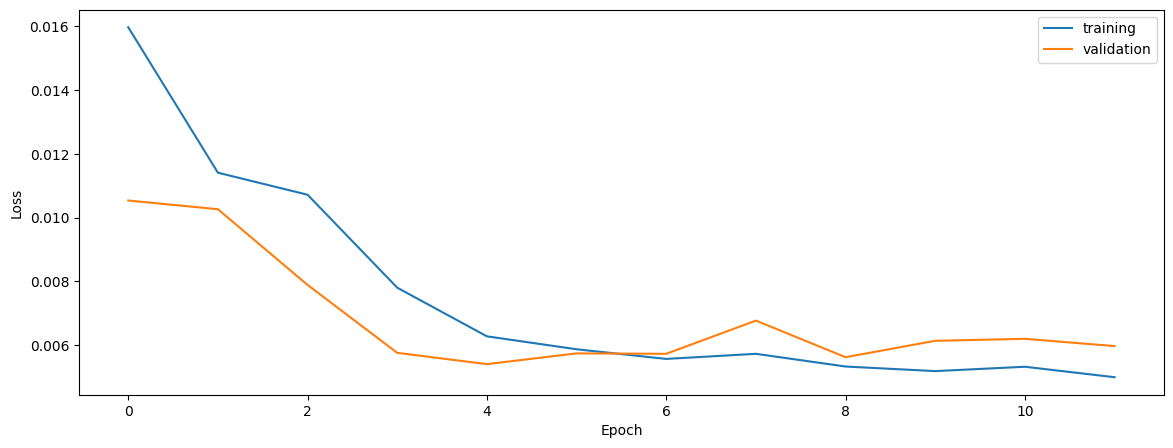

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


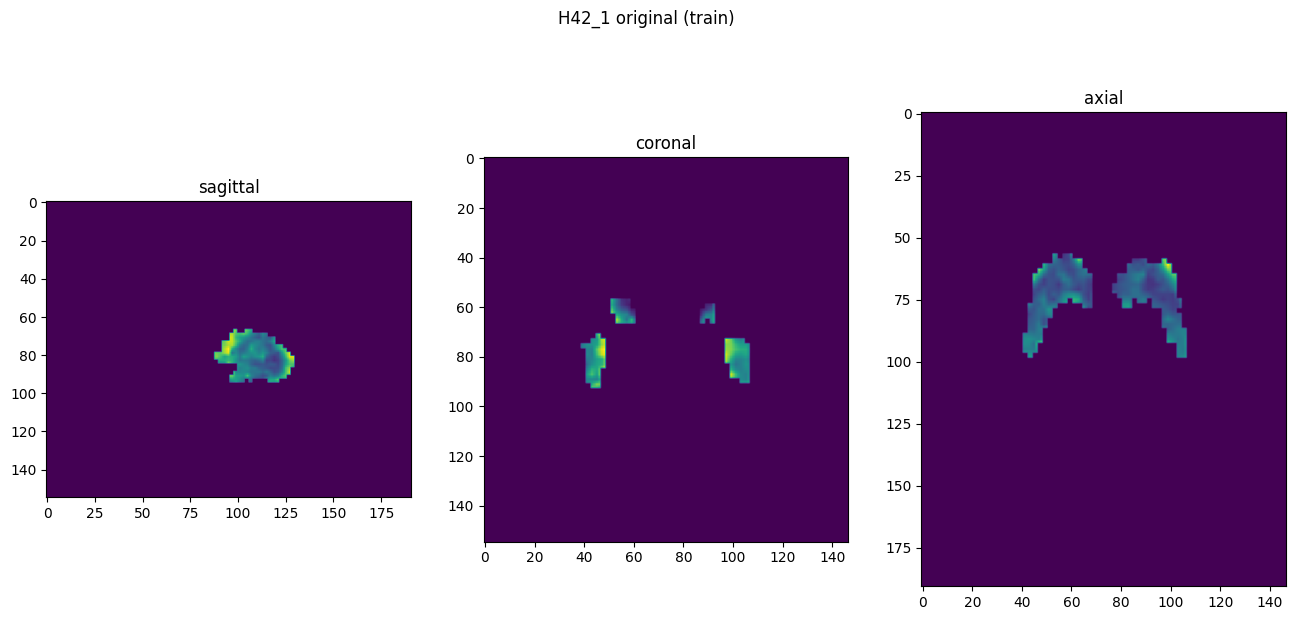

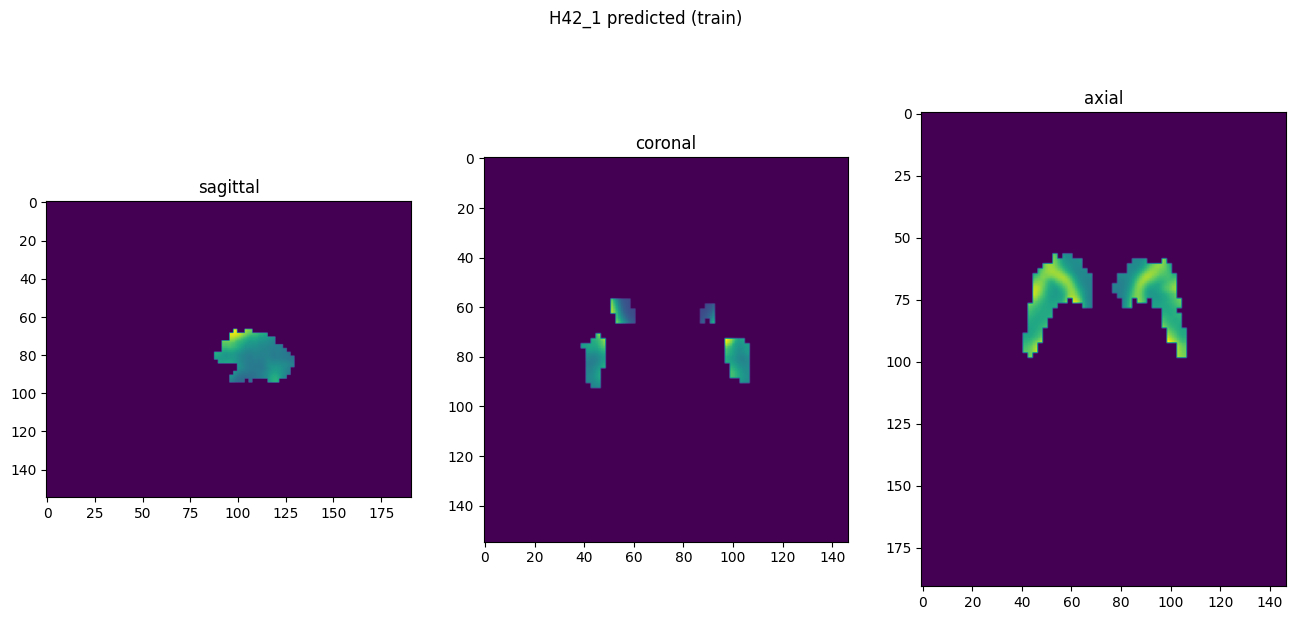

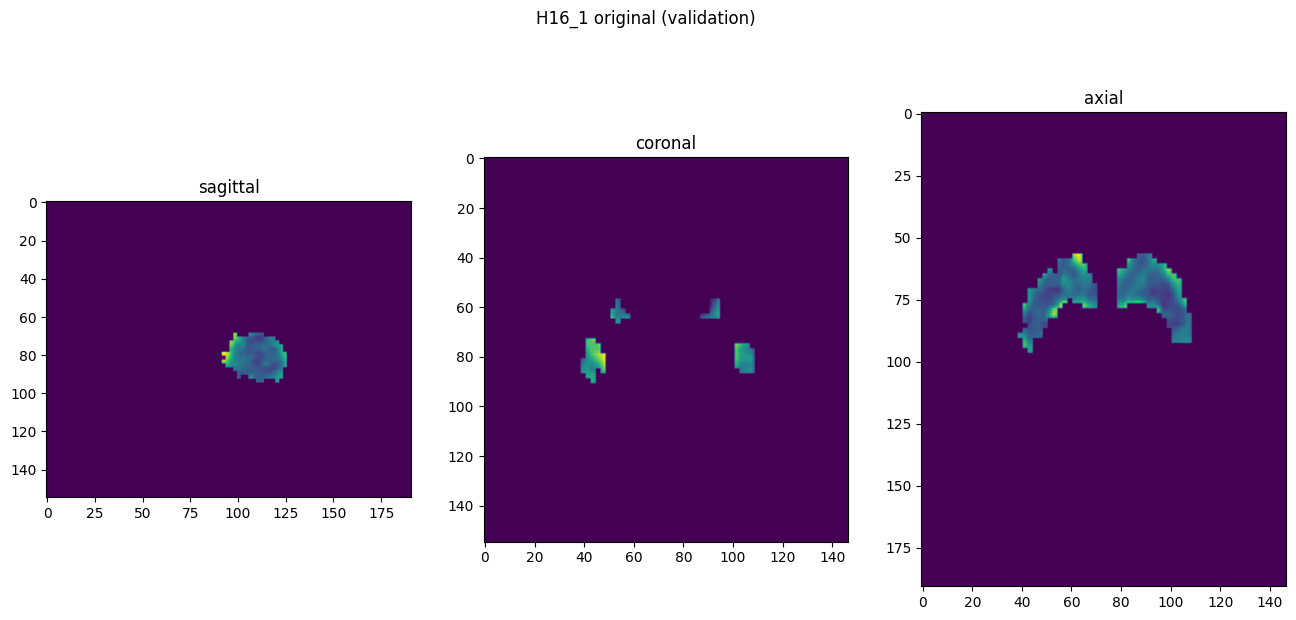

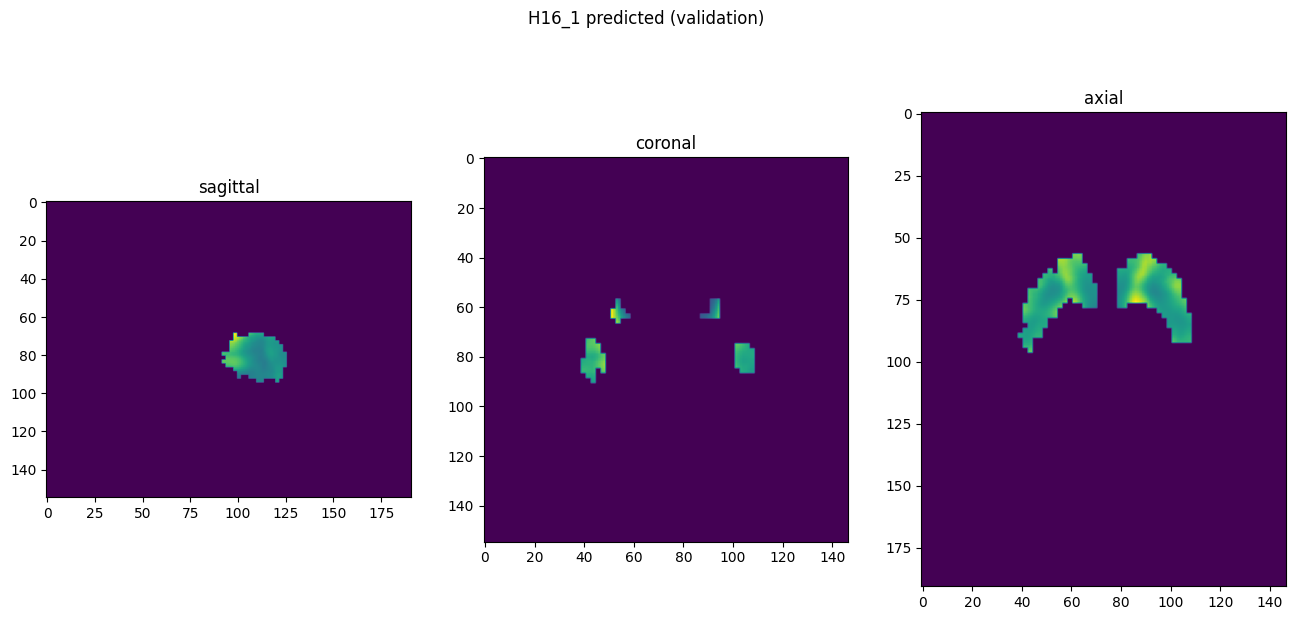

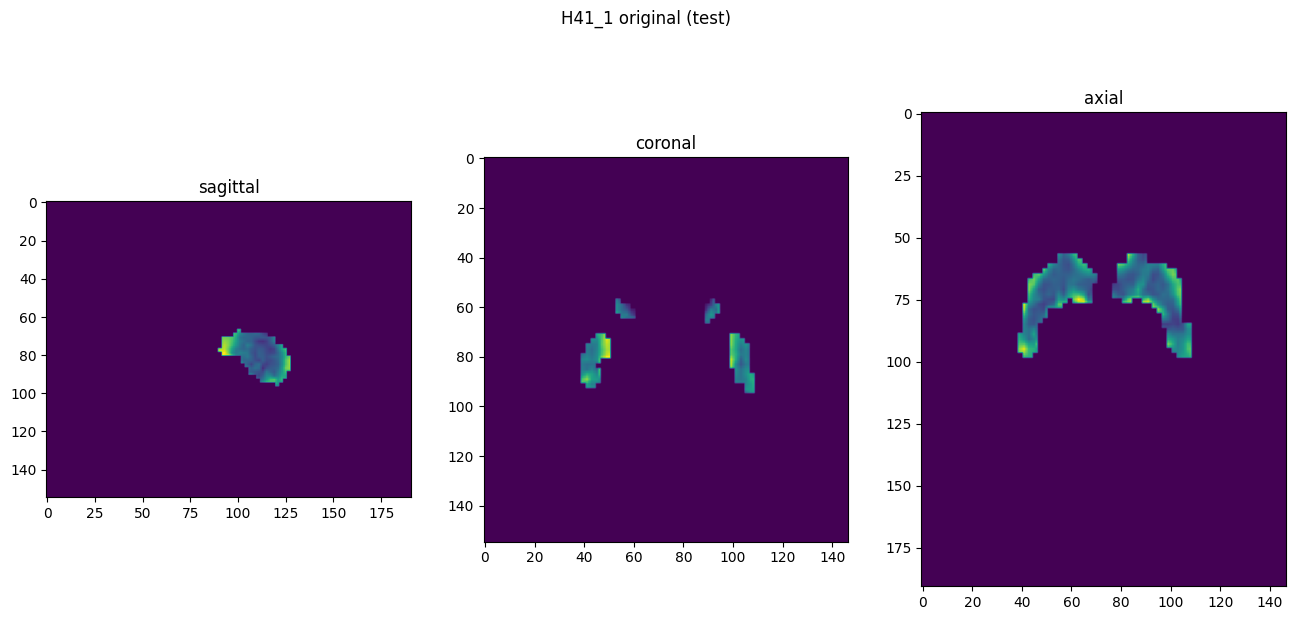

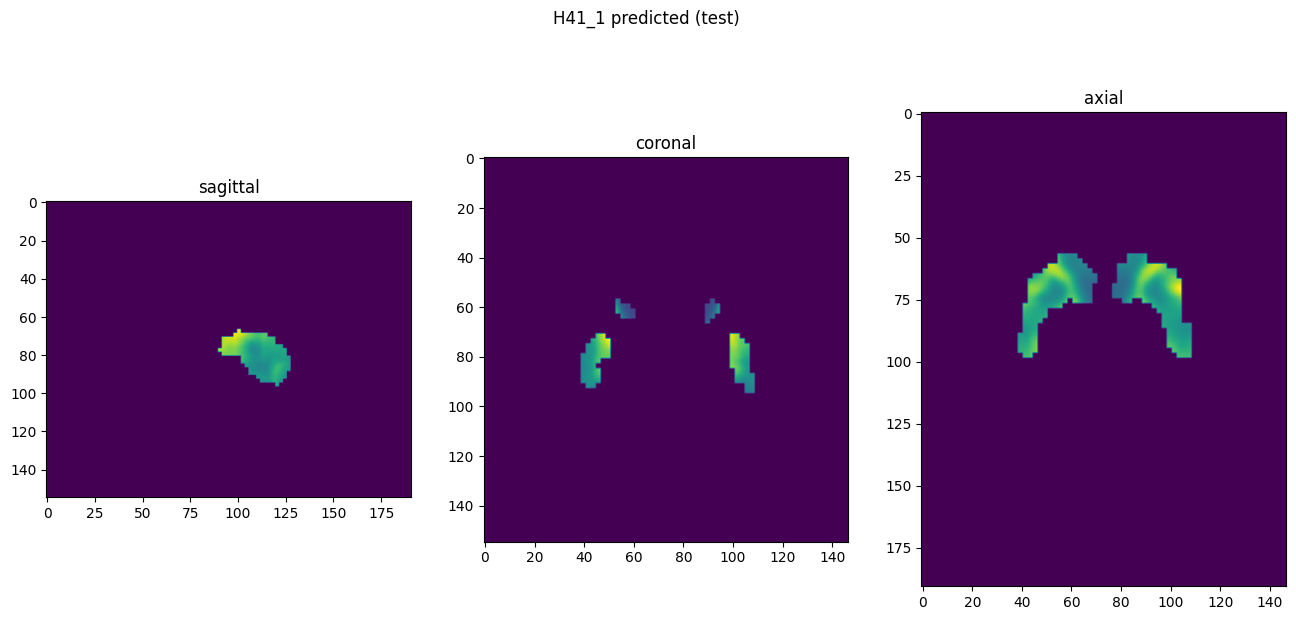

In [10]:
showResults(model, gen, threshold=None, background=False)